### Introduction to Computer Vision (Fall 2022)
Instructor: Muhammad Fahim \\
TA: Batul Yaseen, Karam Almaghout


### Acknowledgement
This lab was maintained by Rauf, Marcus, Rufina, Alex, Batul, Karam and Fahim \\


## Lab Objectives

Contours, Connected Components Labeling, Object Detection, Template Matching, HOG, SVM, Image Pyramids

## Import libraries, download images

In [1]:
# all plots will be set directly below the code cell that produced it
%matplotlib inline
from matplotlib import pyplot as plt
from IPython.display import clear_output
# set inline plots size
plt.rcParams["figure.figsize"] = (16, 10) # (w, h)
# remove grid lines
import numpy as np
import time
import cv2

In [21]:
!wget "https://studyingprayer.files.wordpress.com/2013/12/004.jpg" -O birds.png
!wget https://pics.utro.ru/utro_photos/2018/07/09/1366657.jpg -O football.jpg
!wget "https://github.com/spmallick/learnopencv/blob/master/digits-classification/digits.png?raw=true" -O digits.png
!wget https://pancreapedia.org/sites/default/files/Figure%205a%20-%20CT%20versus%20MRI%20in%20acute%20pancreatitis.jpg -O stomach.jpg
!wget http://www.defunctgames.com/pic/level1-smb1d.jpg -O mario.jpg
!wget https://docs.opencv.org/master/water_coins.jpg -O coins.jpg
!wget https://docs.adaptive-vision.com/4.7/studio/img/machine_vision_guide/template_matching/mount.png -O mount.jpg
!wget https://docs.adaptive-vision.com/4.7/studio/img/machine_vision_guide/template_matching/mounts.png -O mounts.jpg
!wget "https://cs8.pikabu.ru/post_img/big/2016/09/14/10/1473874349129513157.jpg" -O earth.jpg

clear_output()

## Helper functions

In [22]:
# funcrion to read and resize an image
def read_and_resize(filename, grayscale = False, fx= 0.5, fy=0.5):
    if grayscale:
      img_result = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    else:
      imgbgr = cv2.imread(filename, cv2.IMREAD_COLOR)
      # convert to rgb
      img_result = cv2.cvtColor(imgbgr, cv2.COLOR_BGR2RGB)
    # resize
    img_result = cv2.resize(img_result, None, fx=0.5, fy=0.5, interpolation = cv2.INTER_CUBIC)
    return img_result

 
# function for colors arrat generation
def generate_colors(num):
  r = lambda: np.random.randint(0,255)
  return [(r(),r(),r()) for _ in range(num)]
    
def showInRow(list_of_images, titles = None, disable_ticks = False):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx+1)
    if titles is not None:
      subplot.set_title(titles[idx])
      
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
    if disable_ticks:
      plt.xticks([]), plt.yticks([])
  plt.show()

## Check the downloaded images

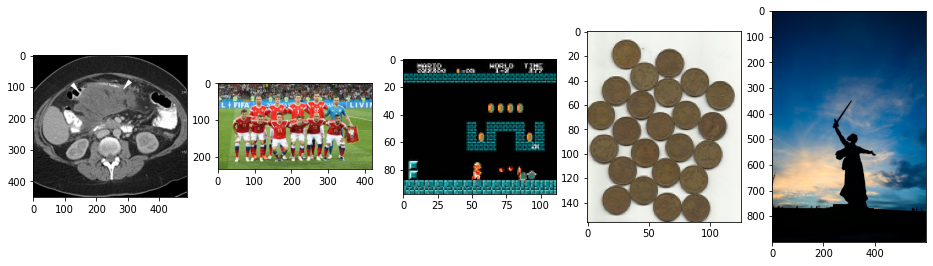

In [23]:
stomach, football = read_and_resize('stomach.jpg'), read_and_resize('football.jpg')
mario, coins, earth = read_and_resize('mario.jpg'), read_and_resize('coins.jpg'), read_and_resize("earth.jpg")
showInRow([stomach, football, mario, coins, earth])

##Contour

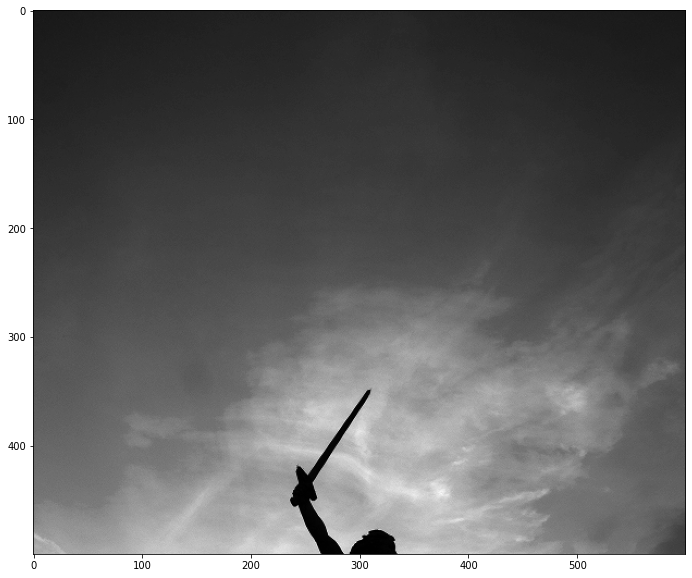

1
Contours type is: <class 'tuple'>
Number of contours: 1
Each contour is: <class 'numpy.ndarray'>
Contour array shape is: (144, 1, 2)


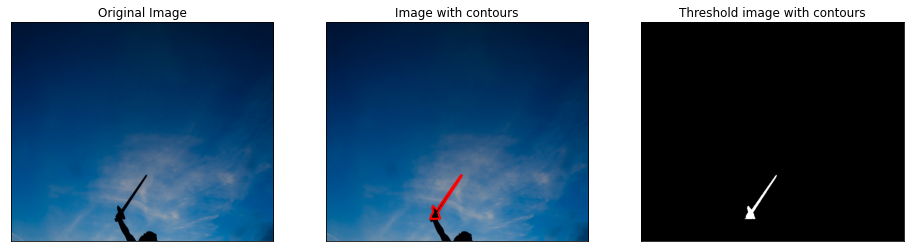

In [5]:
earth = earth[:500]
earth_gray = cv2.cvtColor(earth, cv2.COLOR_RGB2GRAY)
plt.imshow(earth_gray, cmap = 'gray')
plt.show()
earth_gray = 255 - earth_gray
ret, thresh = cv2.threshold(earth_gray, 248, 255, cv2.THRESH_BINARY)

thresh[(thresh.shape[0]-50):,:] = 0
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print(len(contours))
im2 = cv2.drawContours(thresh, contours, -1, (255, 0, 0))
img_contours=earth.copy()

print('Contours type is: {}'.format(type(contours)))
print('Number of contours: {}'.format(len(contours)))
print('Each contour is: {}'.format(type(contours[0])))
print('Contour array shape is: {}'.format(contours[0].shape))

# draw contours on input image
cv2.drawContours(img_contours, contours, -1, (255,0,0), 3)

plt.subplot(131),plt.imshow(earth,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_contours,cmap = 'gray')
plt.title('Image with contours'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(im2,cmap = 'gray')
plt.title('Threshold image with contours'), plt.xticks([]), plt.yticks([])
 
plt.show()

### Contour Features

**Momentum**

(Text(0.5, 1.0, 'Contour center'),
 ([], <a list of 0 Text major ticklabel objects>),
 ([], <a list of 0 Text major ticklabel objects>))

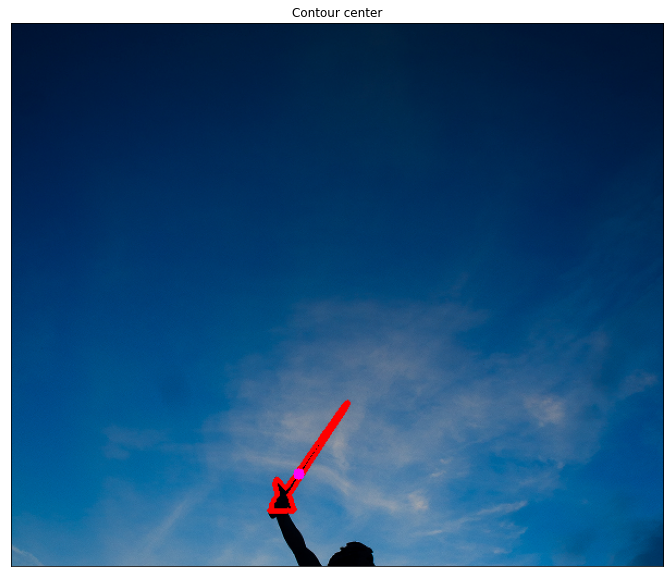

In [6]:
contour = contours[0]
M = cv2.moments(contour)
cx = int(M['m10']/M['m00'])
cy = int(M['m01']/M['m00'])
img_centroid = img_contours.copy()

cv2.circle(img_centroid,(cx,cy), 5, (255,0,255), -1)

plt.imshow(img_centroid)
plt.title('Contour center'), plt.xticks([]), plt.yticks([])

**Contour area**

In [7]:
area = cv2.contourArea(contour)
print('Contour area: {}'.format(area))

Contour area: 788.5


**Contour perimeter**

In [8]:
perimeter = cv2.arcLength(contour,True)
print('Contour perimeter: {}'.format(perimeter))

Contour perimeter: 298.9188268184662


**Contour approximation**

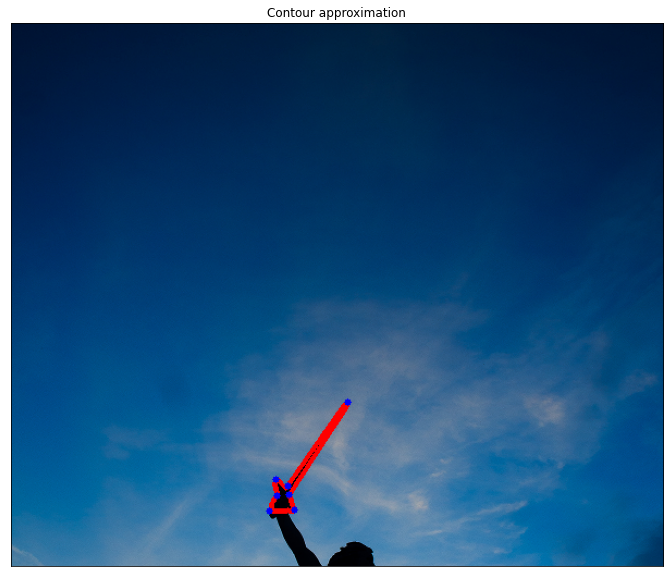

In [24]:
epsilon = 0.01*cv2.arcLength(contour,True)
approx = cv2.approxPolyDP(contour,epsilon,True)

img_approx = img_contours.copy()
cv2.drawContours(img_approx, approx, -1, (0,0,255), 5)
plt.imshow(img_approx)
plt.title('Contour approximation'), plt.xticks([]), plt.yticks([])
plt.show()

**Convex Hull**

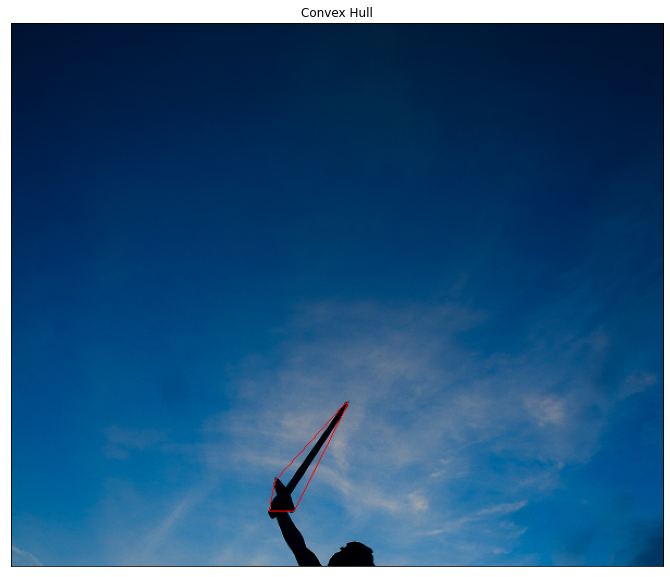

In [16]:
img_hull = earth.copy()
hull_list = []
for i in range(len(contours)):
    hull = cv2.convexHull(contours[i])
    hull_list.append(hull)
for i in range(len(contours)):
      color = (255,0,0)
      cv2.drawContours(img_hull, hull_list, i, color)

plt.imshow(img_hull)
plt.title('Convex Hull'), plt.xticks([]), plt.yticks([])
plt.show()


**Check if contour is convex**

In [17]:
is_convex_contour = cv2.isContourConvex(contour)
is_convex_hull = cv2.isContourConvex(hull)
print('Is our contour convex: {}'.format(is_convex_contour))
print('Is hull convex: {}'.format(is_convex_hull))

Is our contour convex: False
Is hull convex: True


### Bounding shapes

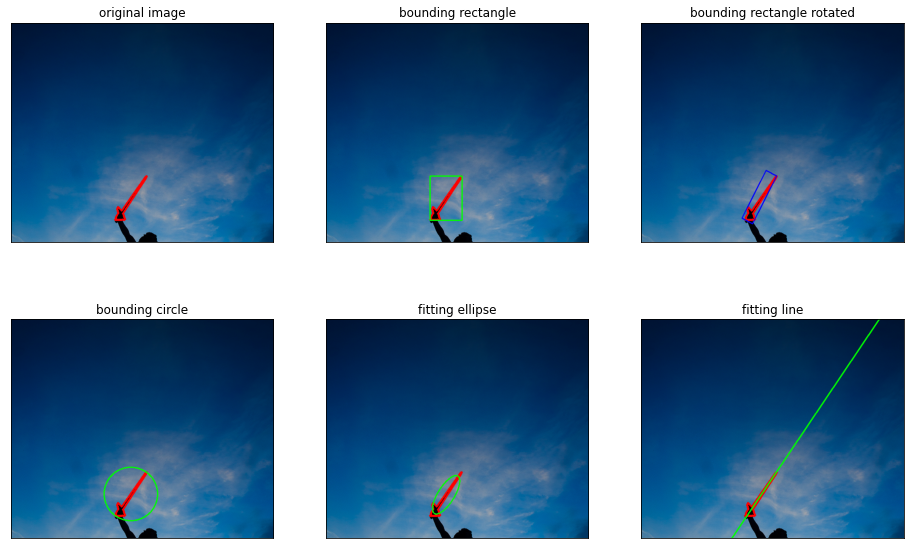

In [18]:
# original image with contour
plt.subplot(231)
plt.imshow(img_contours)
plt.title('original image'), plt.xticks([]), plt.yticks([])

# Bounding rectangle
x,y,w,h = cv2.boundingRect(contour)
img_rectangle = img_contours.copy()
cv2.rectangle(img_rectangle,(x,y),(x+w,y+h),(0,255,0),2)

plt.subplot(232)
plt.imshow(img_rectangle)
plt.title('bounding rectangle'), plt.xticks([]), plt.yticks([])


# Bounding rotated rectangle
rect = cv2.minAreaRect(contour)
box = cv2.boxPoints(rect)
box = np.int0(box)
img_rectangle_rot = img_contours.copy()
cv2.drawContours(img_rectangle_rot,[box],0,(0,0,255),2)

plt.subplot(233)
plt.imshow(img_rectangle_rot)
plt.title('bounding rectangle rotated'), plt.xticks([]), plt.yticks([])


# Bounding circle
(x,y),radius = cv2.minEnclosingCircle(contour)
center = (int(x),int(y))
radius = int(radius)
img_circle = img_contours.copy()
cv2.circle(img_circle,center,radius,(0,255,0),2)

plt.subplot(234)
plt.imshow(img_circle)
plt.title('bounding circle'), plt.xticks([]), plt.yticks([])


# Fitting ellipse
ellipse = cv2.fitEllipse(contour)
img_ellipse = img_contours.copy()
cv2.ellipse(img_ellipse,ellipse,(0,255,0),2)

plt.subplot(235)
plt.imshow(img_ellipse)
plt.title('fitting ellipse'), plt.xticks([]), plt.yticks([])

# Fitting line
img_line = img_contours.copy()
rows,cols = img_line.shape[:2]
[vx,vy,x,y] = cv2.fitLine(contour, cv2.DIST_L2,0,0.01,0.01)
lefty = int((-x*vy/vx) + y)
righty = int(((cols-x)*vy/vx)+y)
cv2.line(img_line,(cols-1,righty),(0,lefty),(0,255,0),2)

plt.subplot(236)
plt.imshow(img_line)
plt.title('fitting line'), plt.xticks([]), plt.yticks([])

plt.show()

### Contour chain approximation

- CHAIN_APPROX_NONE - stores absolutely all contour points;
- CHAIN_APPROX_SIMPLE - compresses horizontal, vertical, and diagonal segments and leaves only their end points. For example, an up-right rectangular contour is encoded with 4 points.

Number of contour points without approximation: 196
Number of contour points with simple approximation: 4


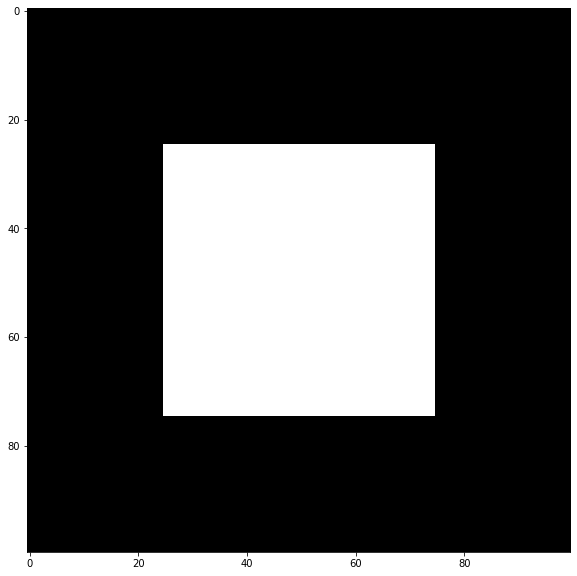

In [19]:
canvas = np.zeros([100, 100],np.uint8)
canvas[25:75,25:75] = 255

plt.imshow(canvas, cmap='gray')

contours1, hierarchy1 = cv2.findContours(canvas, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
contours2, hierarchy2 = cv2.findContours(canvas, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img1 = canvas.copy()
img2 = canvas.copy()
print('Number of contour points without approximation: {}'.format(contours1[0].shape[0]))
print('Number of contour points with simple approximation: {}'.format(contours2[0].shape[0]))

## Connected components

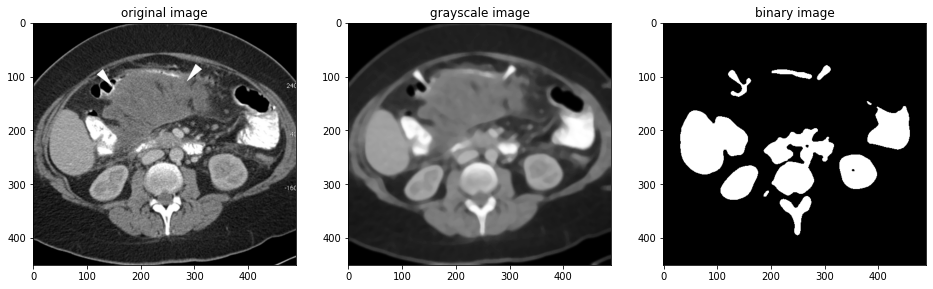

In [24]:
#@title Connected components { run: "auto" }
thresh_val = 136 #@param {type:"slider", min:0, max:255, step:1}

stomach_gray = cv2.cvtColor(stomach, cv2.COLOR_BGR2GRAY)
stomach_gray = cv2.GaussianBlur(stomach_gray,(11,11),0)
stomach_gray = cv2.medianBlur(stomach_gray,9)

# Thresholding
ret,stomach_bw = cv2.threshold(stomach_gray,thresh_val,255,cv2.THRESH_BINARY)

showInRow([stomach, stomach_gray, stomach_bw], ['original image', 'grayscale image', 'binary image'])

labels type is <class 'numpy.ndarray'>
labels shape is (451, 489)
number of labels is 12
centroids coordinates 
 [[247.80161099 222.13769684]
 [298.93674699  92.87349398]
 [140.46065808 114.43490701]
 [241.20806452  95.09677419]
 [382.85294118 150.17647059]
 [423.6743312  198.97059474]
 [ 86.45464289 222.09802202]
 [248.34371957 257.36416748]
 [361.07171429 277.20828571]
 [142.18818453 298.56090275]
 [191.44117647 318.07352941]
 [248.23204748 350.8611276 ]]
[[     0      0    489    451 187586]
 [   286     80     26     28    332]
 [   121     89     43     50    699]
 [   202     88     75     18    620]
 [   379    147      9      7     34]
 [   380    156     79     81   4523]
 [    32    164    126    119  10263]
 [   187    197    131    125   8216]
 [   328    246     70     64   3500]
 [   107    266     70     64   3013]
 [   187    313     10     11     68]
 [   217    323     59     73   1685]]
Connected components parameters:
labeled component 0
leftmost coordinate 286
top 

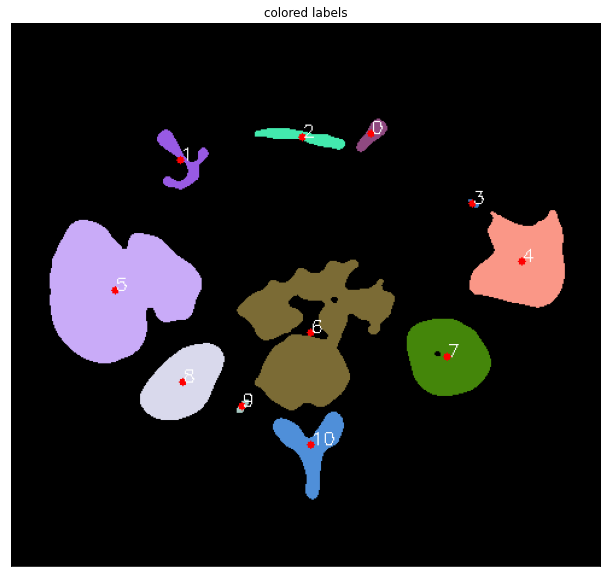

In [25]:
connectivity=4
n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(stomach_bw, connectivity, cv2.CV_32S)

print('labels type is {}'.format(type(labels)))
print('labels shape is {}'.format(labels.shape))
print('number of labels is {}'.format(n_labels))
print('centroids coordinates \n {}'.format(centroids))
print(stats)


colors = generate_colors(n_labels)

labeled_image = np.zeros((stomach_bw.shape[0],stomach_bw.shape[1],3), dtype=np.uint8)

print('Connected components parameters:')
print('================================================')

# loop over all components and determine if it is a number
for (i, label) in enumerate(range(1, n_labels)):
    labeled_image[labels == label,:]= colors[i]
    # centroid coordinates
    cent_x, cent_y = int(centroids[label,0]), int(centroids[label,1])
    cv2.circle(labeled_image,(cent_x, cent_y), 3, (255,0,0), -1)
    cv2.putText(labeled_image, str(i), (cent_x, cent_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5,(255,255,255),1)
    
    print('labeled component {}'.format(i))
    print('leftmost coordinate {}'.format(stats[label, cv2.CC_STAT_LEFT]))
    print('top coordinate {}'.format(stats[label, cv2.CC_STAT_TOP ]))
    print('cc width {}'.format(stats[label, cv2.CC_STAT_WIDTH]))
    print('cc height {}'.format(stats[label, cv2.CC_STAT_HEIGHT ]))
    print('cc area {}'.format(stats[label, cv2.CC_STAT_AREA]))
    print('================================================')
    

plt.title('colored labels')
plt.xticks([]),plt.yticks([])
plt.imshow(labeled_image)
plt.show()

### Highlight components in the source image

The number of organs found in the image is equal to: 11


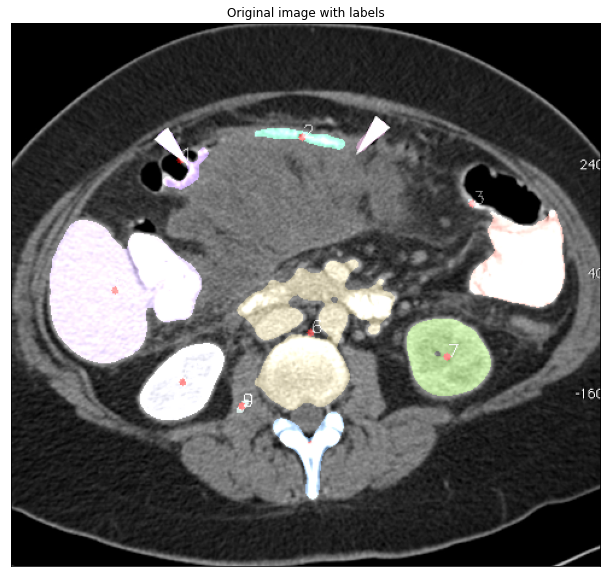

In [26]:
print('The number of organs found in the image is equal to: {}'.format(n_labels-1))
image_with_labels = cv2.addWeighted(stomach,1,labeled_image,0.5,0)
plt.title('Original image with labels')
plt.xticks([]),plt.yticks([])
plt.imshow(image_with_labels)
plt.show()

## Exercise: Calculate number of coins

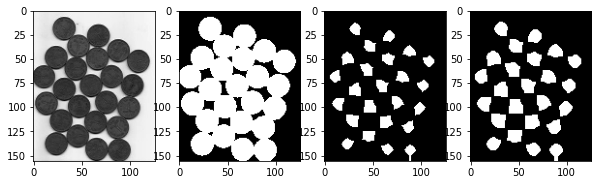

Found 24 labels!


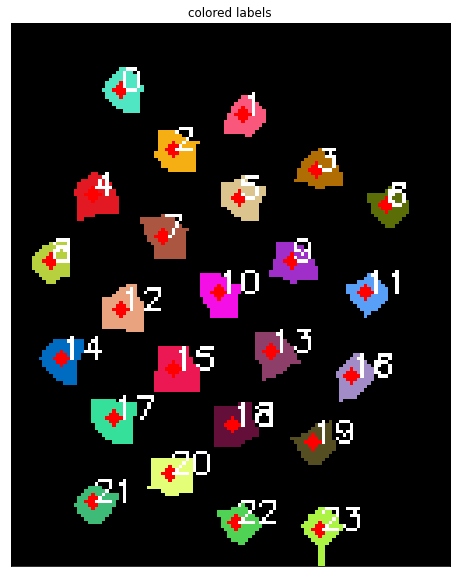

In [27]:
img_gray = read_and_resize('coins.jpg', grayscale = True)
# img_color = read_and_resize_image('keys.jpg')
fig = plt.figure(figsize=(10, 10))

# img_gray = img_gray[100:120, 180:240]
ret, img_gray_bw = cv2.threshold(img_gray,220,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

kernel = np.ones((3,3), np.uint8)
erosion = cv2.erode(img_gray_bw, kernel, iterations = 5)
dilation = cv2.dilate(erosion, kernel, iterations = 1)

showInRow([img_gray, img_gray_bw, erosion, dilation])

# CONNECTED COMPONENTS
connectivity=8
n_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(erosion, connectivity, cv2.CV_32S)

colors = generate_colors(n_labels)
labeled_image = np.zeros((img_gray_bw.shape[0], img_gray_bw.shape[1], 3), dtype=np.uint8)

for (i, label) in enumerate(range(1, n_labels)):
    labeled_image[labels == label, :] = colors[i]
    cent_x, cent_y = int(centroids[label,0]), int(centroids[label,1])
    cv2.circle(labeled_image,(cent_x, cent_y), 2, (255,0,0), -1)
    cv2.putText(labeled_image, str(i), (cent_x, cent_y), cv2.FONT_HERSHEY_SIMPLEX, 0.3,(255,255,255),1)
    
print(f"Found {n_labels-1} labels!")
plt.title('colored labels')
plt.xticks([]),plt.yticks([])
plt.imshow(labeled_image)
plt.show()

## Template matching

**Available methods OpenCV:**  

***CV_TM_SQDIFF***

$$R(x,y)= \sum _{x',y'} (T(x',y')-I(x+x',y+y'))^2$$

***CV_TM_SQDIFF_NORMED***

$$R(x,y)= \frac{\sum_{x',y'} (T(x',y')-I(x+x',y+y'))^2}{\sqrt{\sum_{x',y'}T(x',y')^2 \cdot \sum_{x',y'} I(x+x',y+y')^2}}$$

***CV_TM_CCORR***

$$R(x,y)= \sum _{x',y'} (T(x',y')  \cdot I(x+x',y+y'))$$
  
***CV_TM_CCORR_NORMED***

$$R(x,y)= \frac{\sum_{x',y'} (T(x',y') \cdot I(x+x',y+y'))}{\sqrt{\sum_{x',y'}T(x',y')^2 \cdot \sum_{x',y'} I(x+x',y+y')^2}}$$

***CV_TM_CCOEFF***

$$R(x,y)= \sum _{x',y'} (T'(x',y')  \cdot I(x+x',y+y'))$$

where

$$\begin{array}{l} T'(x',y')=T(x',y') - 1/(w  \cdot h)  \cdot \sum _{x'',y''} T(x'',y'') \\ I'(x+x',y+y')=I(x+x',y+y') - 1/(w  \cdot h)  \cdot \sum _{x'',y''} I(x+x'',y+y'') \end{array}$$

***CV_TM_CCOEFF_NORMED***

$$R(x,y)= \frac{ \sum_{x',y'} (T'(x',y') \cdot I'(x+x',y+y')) }{ \sqrt{\sum_{x',y'}T'(x',y')^2 \cdot \sum_{x',y'} I'(x+x',y+y')^2} }$$


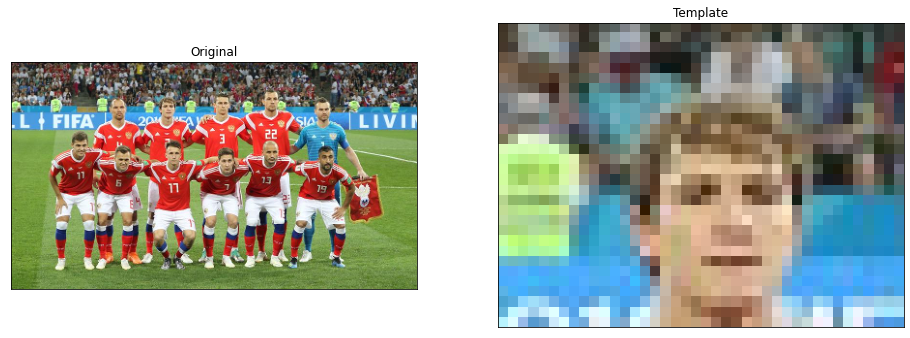

In [28]:
img_template = football[30:60,140:180]
plt.rcParams["figure.figsize"] = (16, 10)
showInRow([football, img_template], ["Original", "Template"], True)

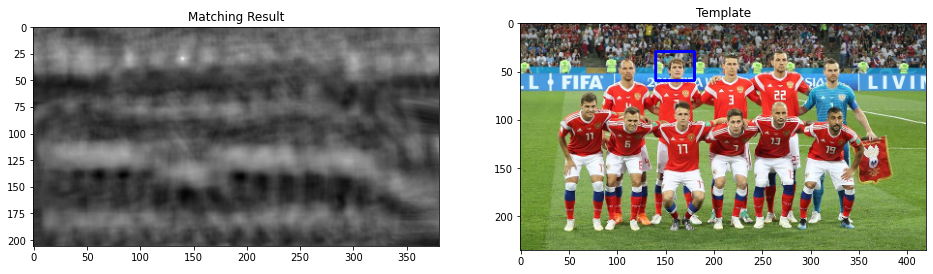

In [29]:
#@title Template matching { run: "auto" }

methods = {'TM_CCOEFF':cv2.TM_CCOEFF, 'TM_CCOEFF_NORMED':cv2.TM_CCOEFF_NORMED, 
           'TM_CCORR':cv2.TM_CCORR, 'TM_CCORR_NORMED':cv2.TM_CCORR_NORMED, 
           'TM_SQDIFF': cv2.TM_SQDIFF, 'TM_SQDIFF_NORMED':cv2.TM_SQDIFF_NORMED}


method = "TM_CCOEFF_NORMED" #@param ["TM_CCOEFF", "TM_CCOEFF_NORMED", "TM_CCORR", "TM_CCORR_NORMED", "TM_SQDIFF", "TM_SQDIFF_NORMED"]

img_detected = football.copy()
h, w, c = img_template.shape
res = cv2.matchTemplate(football,img_template,methods[method])
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

# If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
if method in ['TM_SQDIFF', 'TM_SQDIFF_NORMED']:
    top_left = min_loc
else:
    top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

cv2.rectangle(img_detected,top_left, bottom_right, (0,0,255), 2)
    
    
showInRow([res, img_detected], ['Matching Result', 'Template'])    

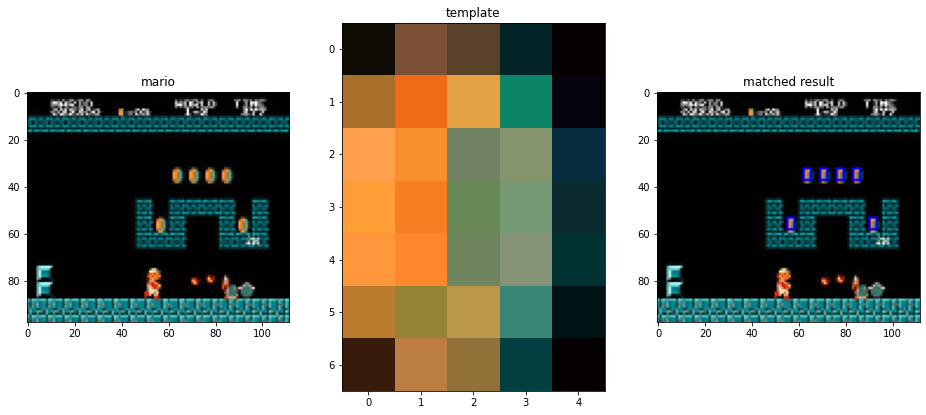

In [30]:
template = mario[32:39,62:67]
w, h, c = template.shape[::-1]
result = mario.copy()
res = cv2.matchTemplate(mario,template,cv2.TM_CCOEFF_NORMED)
threshold = 0.8
loc = np.where( res >= threshold)
for pt in zip(*loc[::-1]):
  cv2.rectangle(result, pt, (pt[0] + w, pt[1] + h), (0,0,255), 1)

showInRow([mario, template, result], ['mario', 'template', 'matched result'])

### Usage of template matching:

1. Rotation invariant matching. We prepare 360 template images and run for each template matching
2. Tracking of object without shape change<br>
![alt text](https://ars.els-cdn.com/content/image/1-s2.0-S111001681730203X-gr9.jpg)
3. Find the same objects of the scene

## Histogram of oriented gradients (HOG) and SVM

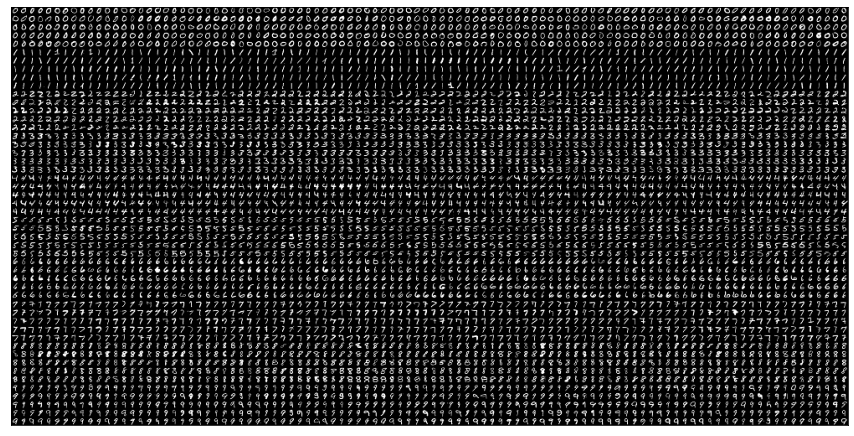

(500, 1000)


In [12]:
img_digits = read_and_resize('digits.png', grayscale = True)
fig = plt.figure(figsize=(15, 15))
plt.imshow(img_digits, 'gray')
plt.xticks([]),plt.yticks([])
plt.show()
print(img_digits.shape)

## Exercise: Train SVM classificator on handwritten digits and recognize number on key tag

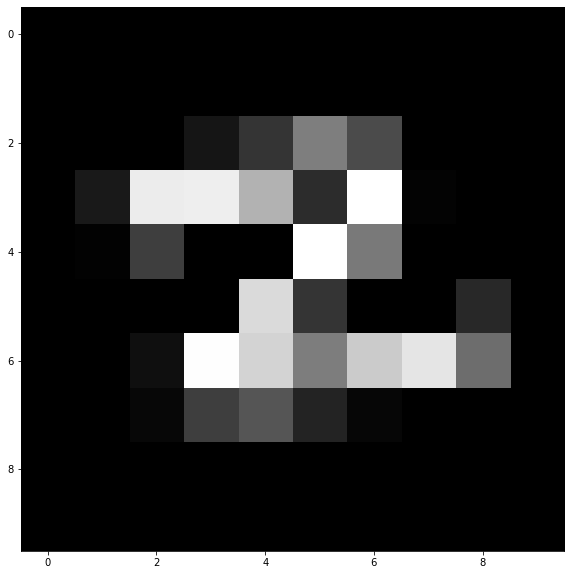

In [13]:
# SPLIT DATA
cells = [np.hsplit(row,100) for row in np.vsplit(img_digits,50)]

# First half is trainData, remaining is testData
train_cells = [ i[:50] for i in cells ]
test_cells = [ i[50:] for i in cells]

showInRow([train_cells[10][10]])

In [14]:
def hog(img, group_size = 3, step = 2, bin_n = 16):
  # calculate gradient
  gx = cv2.Sobel(img, cv2.CV_32F, 1, 0)
  gy = cv2.Sobel(img, cv2.CV_32F, 0, 1)
  # calculate magnitude and angle using cv2.cartToPolar
  mag, ang = cv2.cartToPolar(gx, gy)
  # 
  bins = np.int32(bin_n*ang/(2*np.pi))    # quantizing binvalues in (0...16)
  bin_cells = []
  mag_cells = []
  if step is None: step = group_size

  for r in range(0, img.shape[0]-group_size+1, step):
    for c in range(0, img.shape[1]-group_size+1, step):
      to_r = r + group_size
      to_c = c + group_size
      bin_cells.append(bins[r:to_r, c:to_c])
      mag_cells.append(mag[r:to_r, c:to_c])

  # Create histograms and stack in vector
  hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
  hist = np.hstack(hists)
  
  return hist

hist = hog(train_cells[10][10])
print(hist.shape)
print(hist.dtype)

(256,)
float64


In [15]:

######     Training      ########################

hogdata = [list(map(hog,row)) for row in train_cells]
trainData = np.float32(hogdata)
trainData = trainData.reshape(-1, trainData.shape[2])
print(trainData.shape)
responses = np.int32(np.repeat(np.arange(10),250)[:,np.newaxis])

svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_POLY)
svm.setDegree(3)
svm.trainAuto(trainData, cv2.ml.ROW_SAMPLE, responses)
svm.save('svm_data.dat')

######     Testing      ########################

hogdata = [list(map(hog,row)) for row in test_cells]
testData = np.float32(hogdata)
testData = testData.reshape(-1, testData.shape[2])
result = svm.predict(testData)[1]

# #######   Check Accuracy   ########################
mask = result==responses
correct = np.count_nonzero(mask)
print (correct*100.0/result.size) 

(2500, 256)
92.12


## References

HOG features explanation: [link](https://www.learnopencv.com/histogram-of-oriented-gradients/)  
HOG for car logo recognition: [link](https://gurus.pyimagesearch.com/lesson-sample-histogram-of-oriented-gradients-and-car-logo-recognition/)  
Handwritten digits classification using HOG: [link](https://www.learnopencv.com/handwritten-digits-classification-an-opencv-c-python-tutorial/)
OCR of Hand-written Data using SVM : [link](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_ml/py_svm/py_svm_opencv/py_svm_opencv.html)

Handwritten Digits Classification : [link](https://github.com/spmallick/learnopencv/blob/master/digits-classification/common.py)